# Dementia Diagnosis using moca score
https://www.sciencedirect.com/topics/neuroscience/montreal-cognitive-assessment
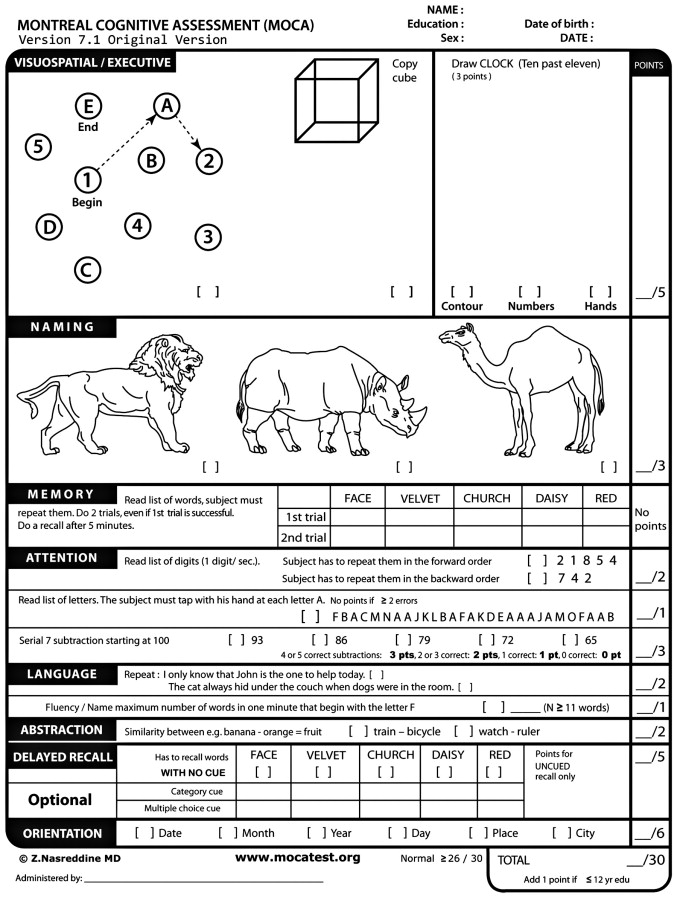
## Preprocessing

In [16]:


import pandas as pd

moca = pd.read_csv('./data/moca.csv')
CRITERIA = ["TRAILS","CUBE",
            "CLOCKCON","CLOCKNO","CLOCKHAN",
            "LION","RHINO","CAMEL",
            "IMMT1W1","IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4","IMMT2W5",
            "DIGFOR","DIGBACK",
            "LETTERS",
            "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
            "REPEAT1","REPEAT2",
            "FFLUENCY",
            "ABSTRAN","ABSMEAS",
            "DELW1","DELW2","DELW3","DELW4","DELW5",
            "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
CRITERIA_NUM = len(CRITERIA)
print(CRITERIA_NUM)
moca = moca[CRITERIA+['VISDATE','PTID']].dropna()
moca['SCORE']=moca[CRITERIA].sum(axis=1)
moca['LETTERS'].value_counts()
moca = moca[moca['LETTERS'] <= 11]


42


In [17]:
# Switch values 1 and 3 in the specified columns
moca[['DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']] = moca[['DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']].replace({1: 3, 3: 1})

In [18]:

moca.to_csv('cleaned_data/moca_clean.csv',index=False)

In [7]:
# Identify columns that have values other than 0 or 1
non_binary_columns = moca.columns[moca.apply(lambda col: col.isin([0, 1]).all() == False)]

# Print the columns
print(non_binary_columns.tolist())


['LETTERS', 'FFLUENCY', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'VISDATE', 'PTID', 'SCORE']


LETTERS
0.0     5487
1.0     1224
2.0      294
3.0      109
4.0       67
11.0      60
5.0       35
9.0       22
6.0       22
7.0       21
10.0      20
8.0       11
12.0       5
13.0       3
29.0       3
21.0       3
18.0       2
16.0       1
15.0       1
22.0       1
19.0       1
25.0       1
23.0       1
Name: count, dtype: int64

In [9]:
diagnosis = pd.read_csv('./cleaned_data/diagnosis_clean.csv').rename(columns={'DATE':'VISDATE'})
moca = pd.merge(moca, diagnosis, on=['PTID','VISDATE'] , how='inner')

## Modeling

In [10]:
from bayesian import *

#find max score
max_score = CRITERIA_NUM
print(moca['SCORE'].describe())
print(parameters4censored_data(moca['SCORE'],min_score=0, max_score=max_score))
print(parameters4each_class(moca,min_score=0, max_score=max_score))

count    2295.000000
mean       52.407407
std         8.641107
min        11.000000
25%        48.000000
50%        54.000000
75%        58.000000
max        84.000000
Name: SCORE, dtype: float64
[62.39853332120019, 15.963569549630424]
{0.0: [67.42949474404911, 10.507912949385673], 1.0: [57.96200141841094, 10.131839589759718], 2.0: [42.46443501601926, 11.54029502524809]}


In [11]:
# Initial weights
weights = np.ones(len(CRITERIA))

# Constraints: weights >= 0
bounds = [(1, 10) for _ in CRITERIA]
# print(classifier_loss(initial_weights, moca, CRITERIA, 1))
labels = moca['DIAGNOSIS'].values.astype(int)  # Ensure labels are integers from 0 to num_classes - 1
ground_truth = np.eye(3)[labels]  # One-hot encode the labels
class_priors = moca['DIAGNOSIS'].value_counts(normalize=True)

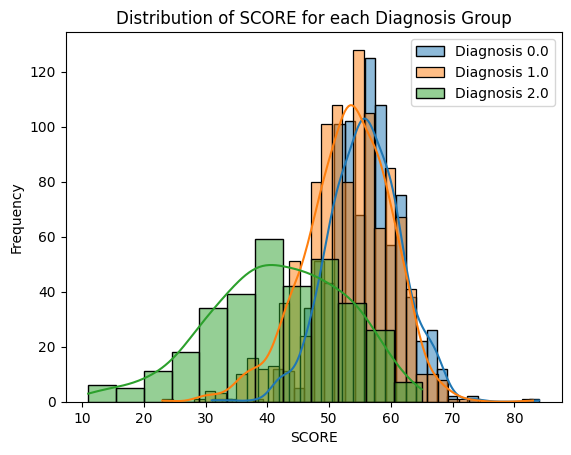

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the moca dataframe by the "DIAGNOSIS" column
grouped_df = moca.groupby("DIAGNOSIS")

# Create a figure and axes for the plot
fig, ax = plt.subplots()

# Iterate over each diagnosis group
for diagnosis, group in grouped_df:
    # Plot the distribution of "SCORE" for the current diagnosis group
    sns.histplot(data=group, x="SCORE", kde=True, label=f"Diagnosis {diagnosis}")

# Set the title and labels for the plot
ax.set_title("Distribution of SCORE for each Diagnosis Group")
ax.set_xlabel("SCORE")
ax.set_ylabel("Frequency")

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

In [13]:
labels = moca['DIAGNOSIS'].values.astype(int)

In [14]:
from sklearn.metrics import accuracy_score
max_score= weights.sum()
accuracy = accuracy_score(moca['DIAGNOSIS'], bayesian_classifier(moca,max_score=max_score,class_priors=class_priors))

print(accuracy)

0.5071895424836601


In [43]:
from flaml import AutoML
automl = AutoML()

# Specify the estimators you want to test
estimators_to_test = ['lgbm', 'lrl1','xgboost','rf', 'extra_tree','lrl2']

# Iterate over each estimator
for estimator in estimators_to_test:
    print(f"\nTesting estimator: {estimator}")
    
    # Configure AutoML for each estimator
    automl_settings = {
        "task": 'classification',
        "estimator_list": [estimator],  # Test one estimator at a time
        "verbose": 0,  # silent mode
    }

    # Train the model
    automl.fit(X_train=moca['SCORE'].to_numpy() , y_train=moca['DIAGNOSIS'].to_numpy() , **automl_settings)

    # Make predictions
    y_pred = automl.predict(moca['SCORE'].to_numpy().reshape(-1, 1))

    # Calculate accuracy
    accuracy = accuracy_score(moca['DIAGNOSIS'].to_numpy() , y_pred)
    print(f"Accuracy for {estimator}: {accuracy:.4f}")



Testing estimator: lgbm
Accuracy for lgbm: 0.5529

Testing estimator: lrl1
Accuracy for lrl1: 0.4885

Testing estimator: xgboost


c:\Users\yeon0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy for xgboost: 0.5538

Testing estimator: rf
Accuracy for rf: 0.5542

Testing estimator: extra_tree
Accuracy for extra_tree: 0.5542

Testing estimator: lrl2
Accuracy for lrl2: 0.5307
